# Example 1 - Basic Feed-forward Autoencoder for Basic Dimensionality Reduction

In this notebook we will train a small autoencoder comprising of some dense layers, for image reconstruction on a emoji dataset. 

In [1]:
import tensorflow as tf


from tqdm.notebook import tqdm
from tqdm.keras import TqdmCallback

from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Identity, Conv2DTranspose, BatchNormalization, Flatten, Reshape, Dense
from keras.callbacks import EarlyStopping

2024-01-16 11:12:51.653753: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-16 11:12:51.653798: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-16 11:12:51.655208: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-16 11:12:51.663293: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-16 11:12:52.494152: W tensorflow/compiler/tf2

In [2]:
from utils import get_preprocessed_emoji, plot_loss, evaluate_autoencoder

In [3]:
# For simplicity, let's work with smaller images, 32x32
x_train, x_test = get_preprocessed_emoji(resized_size=32)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/749 [00:00<?, ?it/s]

In [18]:
inferred_size = x_train.shape[1]

encoder = tf.keras.Sequential([
    Input(shape=(inferred_size, inferred_size, 3)),
    Flatten(),
    Dense(192, activation='relu')  # 192 = 8*8*3
    
])

decoder = tf.keras.Sequential([
    Dense(32*32*3, activation='sigmoid'),
    Reshape((32, 32, 3)),
])


autoencoder = tf.keras.Sequential([encoder, decoder])

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [23]:
autoencoder.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 192)               590016    
                                                                 
 sequential_7 (Sequential)   (None, 32, 32, 3)         592896    
                                                                 
Total params: 1182912 (4.51 MB)
Trainable params: 1182912 (4.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


0epoch [00:00, ?epoch/s]

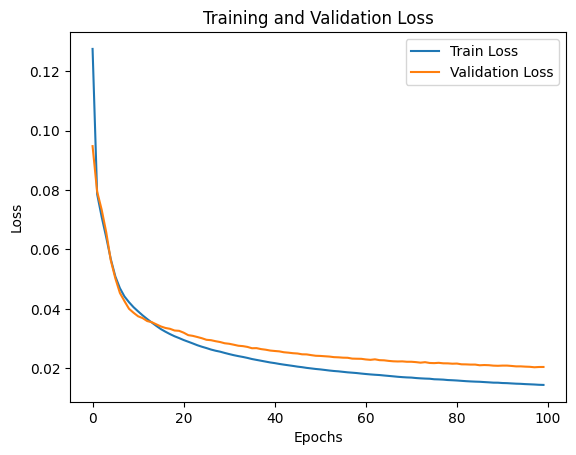

In [19]:
history = autoencoder.fit(
    x_train, x_train, 
    epochs=100, batch_size=256, validation_data=(x_test, x_test), 

    # Only show progress for epochs:
    verbose=0,
    callbacks=[TqdmCallback(verbose=0)],
)

plot_loss(history)

## Evaluate the results

Our evaluate_autoencoder utility function will plot three sets of images: 
 - The original images ("Originals")
 - The reconstructions from the autoencoder ("AE Recovered")
 - The reconstructions from a "baseline" encoder.

The baseline "model" is not a trained neural network - rather, it just downsamples the images to use the same dimensionality as the autoencoder's embedding.  For example, here our autoencoder has an embedding of 192 dimensions, so the images are downsampled to 8x8 (8x8x3 channels = 192).  

With any luck, the autoencoder we train will have better reconstruction than this baseline.

63/63 [==============================] - 0s 2ms/step
Bottleneck layer size: 192, equivalent_downsample=8
Recovered MSE: 0.014305164106190205
Baseline MSE:  0.022099271416664124
Originals:


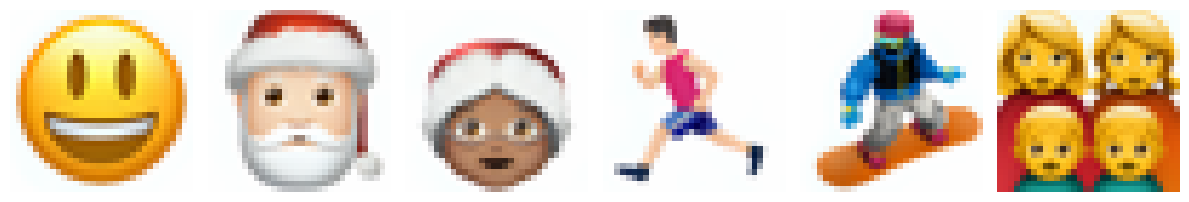

AE Recovered:


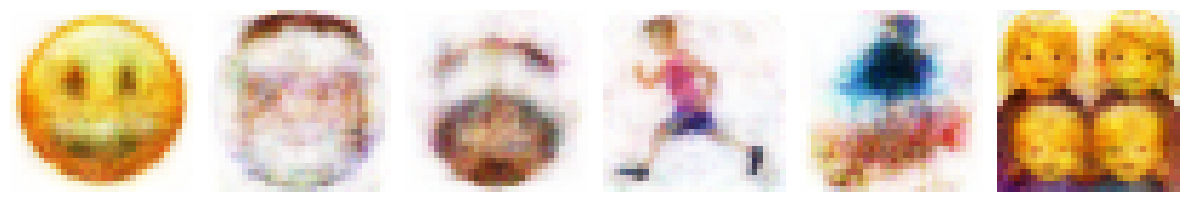

Downsample/Upsample baseline:


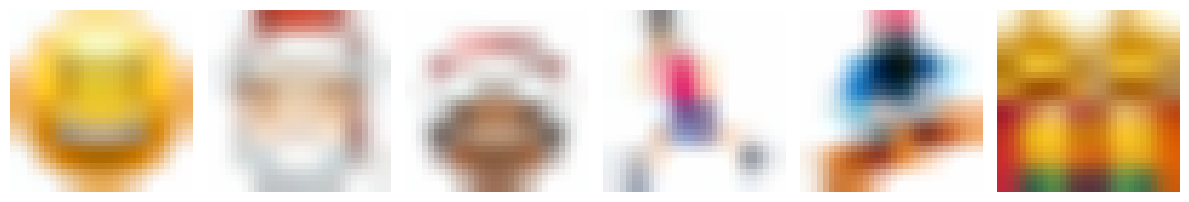

In [20]:
evaluate_autoencoder(autoencoder, x_train)

## Summary

This basic autoencoder has learned a reasonable 192-dimensional representation of the emoji dataset.  Yes, the reconstructions look compressed, but this is expected - we started with 32x32x3 images represented as 3072 numbers, and squeezed this down into a bottleneck layer of only 192 numbers.

Overall the reconstructions look acceptable, and the MSE loss is also better than the baseline. 


### Note on out-of-sample evaluation

Sometimes, out of simplicity / laziness / general bad practice, I will just evaluate on the training set.  I'm not trying to pull a fast one on ya - I just want to focus on keeping the examples simple and show the core ideas, without spending too much time worrying about looking for bigger datasets that are less prone to overfitting, adding regularization layers, etc. 

The general narrative in these notebooks should hold even on out-of-sample data, even if that means spending more time tuning the models or training longer.

To keep me honest, feel free to evaluate on the test dataset -- you can visualize the entire dataset, or some specific images.  There's a code example below.

24/24 [==============================] - 0s 1ms/step
Bottleneck layer size: 192, equivalent_downsample=8
Recovered MSE: 0.020419541746377945
Baseline MSE:  0.019789811223745346
Originals:


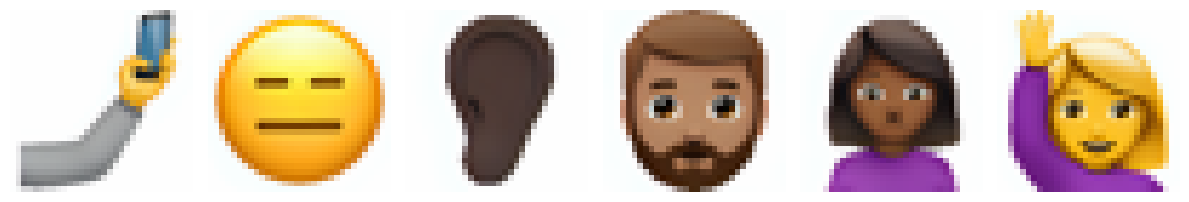

AE Recovered:


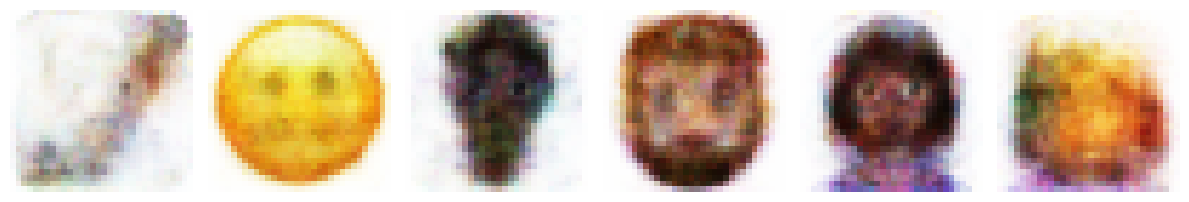

Downsample/Upsample baseline:


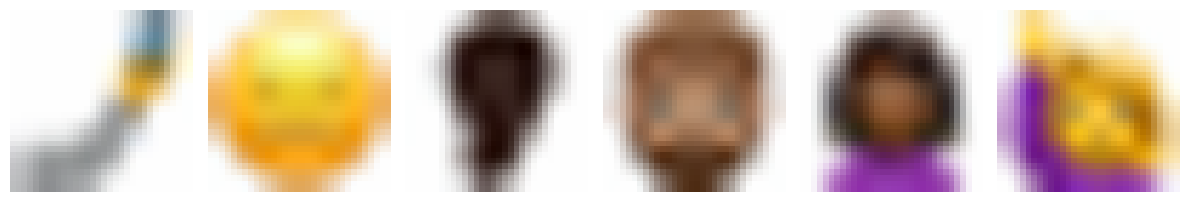

In [21]:
evaluate_autoencoder(autoencoder, x_test, idxs=[3, 17, 35, 101, 202, 303])